In [1]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
from networkx.algorithms import bipartite
import numpy as np
from collections import deque
from math import isclose
import random
import pickle
from time import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

In [2]:
random.seed(73)
env = gp.Env(empty=True)
# env.setParam("Threads", 16)
env.setParam("OutputFlag",0) # suppress gurobi console output
env.start()

def run_experiments(input_file, lambda_mul):
    print(f'============================================================')
    print(f'===== Running the algorithm for lambda = {lambda_mul} ======')
    lambda_ = lambda_mul * sum(w.values()) / n
    
    # Create a new model
    m = gp.Model("quadratic", env=env)
    m.Params.timeLimit = 120
    m.Params.NonConvex = 2

    # Create variables
    X = dict()
    Y = dict()
    for u in nodes:
        for p in projects:
            X[(u, p)] = m.addVar(vtype=GRB.BINARY, name=f"X({u},{p})")

    for p in projects:
        Y[p] = m.addVar(vtype=GRB.BINARY, name=f"Y_{p})")


    # Linear (project preference) term
    threshold = (numOfUniqueProjects - 3 + 1) / numOfUniqueProjects
    F1 = gp.LinExpr()
    for u in nodes:
        for p in projects:
            if (u, p) in c:
                if penalize and c[(u, p)] < threshold:
                    F1 -= 100 * X[(u, p)]
                else:
                    F1 += c[(u, p)] * X[(u, p)]
    F1 *= lambda_

    # max-cut term
    F3 = dict()
    F2 = gp.QuadExpr()
    for e in edges:
        u = e[0]; v = e[1]
        F3[e] = gp.QuadExpr()
        for p in projects:
            F3[e] -=  X[(u, p)] * X[(v, p)]
        F3[e] += 1
        F3[e] *= w[(u, v)]
    for e in edges:
        F2 += F3[e]

    F = gp.QuadExpr()
    F = F1 + F2
    m.setObjective(F, GRB.MAXIMIZE)

    # Add constraints

    # Each student assigned to exactly one project
    for u in nodes:
        expr = gp.QuadExpr()
        expr = sum([Y[p] * X[(u, p)] for p in projects])
        m.addConstr(expr == 1)
        expr = sum([X[(u, p)] for p in projects])
        m.addConstr(expr == 1)

    # Project capacity constraints
    for p in projects:
        expr = gp.QuadExpr()
        expr = Y[p] * sum(X[(u, p)] for u in nodes)
        m.addConstr(expr <= capacities[p])
        m.addConstr(expr >= min_capacities[p] * Y[p])
        expr = sum(X[(u, p)] for u in nodes)
        m.addConstr(expr <= capacities[p])


    # Number of "active" projects
    expr = gp.LinExpr()
    expr = sum([Y[p] for p in projects])
    print(f'# active projects = {P}')
    m.addConstr(expr == P)
    
    start = time()
    # Optimize model
    m.optimize()

    # Convert solution to dictionary format
    x = dict()
    for u in nodes:
        for p in projects:
            if isclose(X[(u, p)].X, 1):
                x[(u, p)] = 1
    return x

In [3]:
def construct_teams(x):
    teams = dict()
    for p in projects:
        teams[p] = []

    for e in x:
        u, p = e
        if isclose(x[e], 1):
            teams[p].append(u)
            
    for p in projects:
        teams[p].sort()
        
    return teams
    
def min_friends(teams):
    minFriends = n
    for team in teams.values():
        for u in team:
            friends = sum([1 for v in team if u != v and (u, v) not in w and (v, u) not in w])
            minFriends = min(friends, minFriends)
    return minFriends
            
def max_friends(teams):
    maxFriends = 0
    for team in teams.values():
        for u in team:
            friends = sum([1 for v in team if u != v and (u, v) not in w and (v, u) not in w])
            maxFriends = max(friends, maxFriends)
    return maxFriends

def avg_friends(teams):
    friends = 0
    for team in teams.values():
        friends += sum([1 for u in team for v in team if u != v and (u, v) not in w and (v, u) not in w])
    return friends / n

def reverse_pref(pref):
#     return 1 / pref
    return numOfUniqueProjects - pref*numOfUniqueProjects + 1

def min_preference(teams):
    ans = 1
    for t in teams:
        team = teams[t]
        for u in team:
            ans = min(ans, reverse_pref(c[(u, t)]))      
    return ans
            
def max_preference(teams):
    ans = -1
    for t in teams:
        team = teams[t]
        for u in team:
            ans = max(ans, reverse_pref(c[(u, t)]))      
    return ans

def avg_preference(teams):
    pref = 0
    for t in teams:
        team = teams[t]
        pref += sum([reverse_pref(c[(u, t)]) for u in team])
    return pref / n

def friends_distribution(teams):
    dist = deque()
    for team in teams.values():
        for u in team:
            friends = sum([1 for v in team if u != v and (u, v) not in w and (v, u) not in w])
            dist.append(friends)
    return dist

def find_friends(student, teams):
    if student not in nodes:
        return "Not a valid student"
    friends = []
    for team in teams.values():
        for u in team:
            if u == student:
                friends = [v for v in team if u != v and (u, v) not in w and (v, u) not in w]
                return friends
    return []

def find_preference(student, teams):
    if student not in nodes:
        return "Not a valid student"
    for t in teams:
        team = teams[t]
        for u in team:
            if u == student:
                return reverse_pref(c[(u, t)])
    return "find_preference error"

def project_distribution(teams):
    dist = deque()
    for t in teams:
        team = teams[t]
        for u in team:
            dist.append(reverse_pref(c[(u, t)]))
    return dist

def group_keys_by_value(input_dict):
    grouped_dict = {}
    
    for key, value in input_dict.items():
        if value in grouped_dict:
            grouped_dict[value].append(key)
        else:
            grouped_dict[value] = [key]
    
    return grouped_dict
        
def draw_graph_with_teams(teams, pos, title):
    activeTeams = [t for t in teams if teams[t]]
    colors = sns.color_palette("tab10", len(activeTeams))
#     colors = cm.rainbow(np.linspace(0, 1, len(teams)))
    colors_dict = dict(zip(sorted(activeTeams), colors))

    color_map = []
    for node in G:
        for team in teams:
            if node in teams[team]:
                color_map.append(colors_dict[team])
                break

    nx.draw(G_c, node_color=color_map, pos=pos, with_labels=True)
    plt.title(title)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color, markeredgecolor=color) for color, label in zip(colors, colors_dict.keys())]
    plt.legend(handles=legend_handles)
    plt.show()

In [4]:
def analysis(x):
    # ==== Friends graph =====
    print(f'Num of students = {len(nodes)}')
    print(f'Num of (friend) edges = {len(G_c.edges)}')
#     nx.draw(G_c, pos=nx.spring_layout(G_c, k=0.2, iterations=20), with_labels=True)
    
    # ==== Construct the team =====
    teams = construct_teams(x)
    print("Teams: ")
    for t in teams:
        print(f'team {t}: {teams[t]}')
    
    # ==== Solution statistics ====
    print(f'(optimal assignment) avg number of friends {avg_friends(teams)}')
    print(f'(optimal assignment) min number of friends {min_friends(teams)}')
    print(f'(optimal assignment) max number of friends {max_friends(teams)}')

    print(f'(optimal assignment) avg preference {avg_preference(teams)}')
    print(f'(optimal assignment) min preference {min_preference(teams)}')
    print(f'(optimal assignment) max preference {max_preference(teams)}')

    # ==== Per student analysis ====
    print('===== Per student analysis =====')
    print('student {id}: {project_preference}, {friends}')
    for u in nodes:
        opt_pref = find_preference(u, teams)
        opt_friends = find_friends(u, teams)
        print(f"student {u}: {opt_pref}, {opt_friends}")

    # ===== Draw graph =====
    draw_graph_with_teams(teams, pos, 'Friends and team assignment')


In [5]:
input_file = 'cs549.pickle'
lambda_mul = 1
numOfUniqueProjects = 7 # num of unique projects

# Read graph
with open(input_file, 'rb') as file:
    projects = pickle.load(file)
    capacities = pickle.load(file)
    numOfProjects = len(capacities)
    c = pickle.load(file)
    w = pickle.load(file)
    edges = pickle.load(file)
    full_ids = pickle.load(file)
    
    G = nx.Graph()
    G.add_edges_from(edges)
    G_c = nx.complement(G) # friends graph
    pos=nx.spring_layout(G_c, k=0.2, iterations=20)
    nodes = list(G.nodes)
    n = len(nodes)
    P = 7 # max number of "active" projects
    min_capacities = dict()
    for p in projects:
        min_capacities[p] = 3

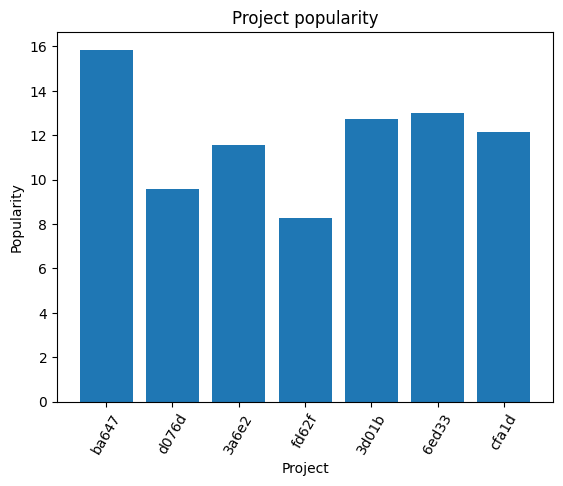

In [6]:
proj_popularity = dict()
for p in projects:
    proj_popularity[p] = 0
    
for u in nodes:
    for p in projects:
        if (u, p) in c:
            proj_popularity[p] += c[(u, p)]
            
xs = projects
ys = proj_popularity.values()

plt.bar(xs, ys)
plt.xlabel('Project')
plt.xticks(rotation = 60)
plt.ylabel('Popularity')
plt.title(f'Project popularity')

plt.show()

### Consideration set A
- 7 active teams

===== Running the algorithm for lambda = 0.1 ======
# active projects = 7
Num of students = 21
Num of (friend) edges = 14
Teams: 
team ba647: ['5d51f', 'cc7d7', 'f495b']
team d076d: ['33c10', '47587', 'f13e4']
team 3a6e2: ['57514', '9b140', 'a61a9']
team fd62f: ['8870e', '95bb9', 'f13d2']
team 3d01b: ['752e4', 'b1292', 'e1015']
team 6ed33: ['0337a', '05f6c', '623f3']
team cfa1d: ['12e49', '77640', 'b4122']
(optimal assignment) avg number of friends 1.0476190476190477
(optimal assignment) min number of friends 0
(optimal assignment) max number of friends 2
(optimal assignment) avg preference 1.380952380952381
(optimal assignment) min preference 1
(optimal assignment) max preference 3.0
===== Per student analysis =====
student {id}: {project_preference}, {friends}
student 77640: 1.0, ['12e49']
student b1292: 2.0, ['e1015']
student e1015: 2.0, ['b1292']
student 752e4: 2.0, []
student f495b: 1.0, ['5d51f', 'cc7d7']
student 5d51f: 1.0, ['cc7d7', 'f495b']
student 47587: 1.0, ['33c10', 'f13e4

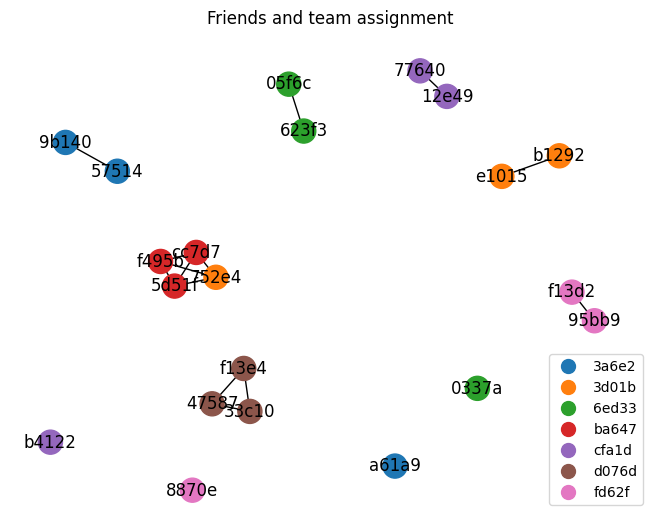

In [7]:
penalize = True
for l in [0.1]:
    lambda_mul = l
    x = run_experiments(input_file, lambda_mul)
    analysis(x)

### Consideration set B
- 6 active projects

===== Running the algorithm for lambda = 0.1 ======
# active projects = 6
Num of students = 21
Num of (friend) edges = 14
Teams: 
team ba647: ['5d51f', '752e4', 'cc7d7', 'f495b']
team d076d: ['33c10', '47587', 'f13e4']
team 3a6e2: ['57514', '9b140', 'a61a9']
team fd62f: ['8870e', '95bb9', 'f13d2']
team 3d01b: ['05f6c', '623f3', 'b1292', 'e1015']
team 6ed33: []
team cfa1d: ['0337a', '12e49', '77640', 'b4122']
(optimal assignment) avg number of friends 1.3333333333333333
(optimal assignment) min number of friends 0
(optimal assignment) max number of friends 3
(optimal assignment) avg preference 1.4761904761904763
(optimal assignment) min preference 1
(optimal assignment) max preference 3.0
===== Per student analysis =====
student {id}: {project_preference}, {friends}
student 77640: 1.0, ['12e49']
student b1292: 2.0, ['e1015']
student e1015: 2.0, ['b1292']
student 752e4: 1.0, ['5d51f', 'cc7d7', 'f495b']
student f495b: 1.0, ['5d51f', '752e4', 'cc7d7']
student 5d51f: 1.0, ['752e4', 'cc7d7',

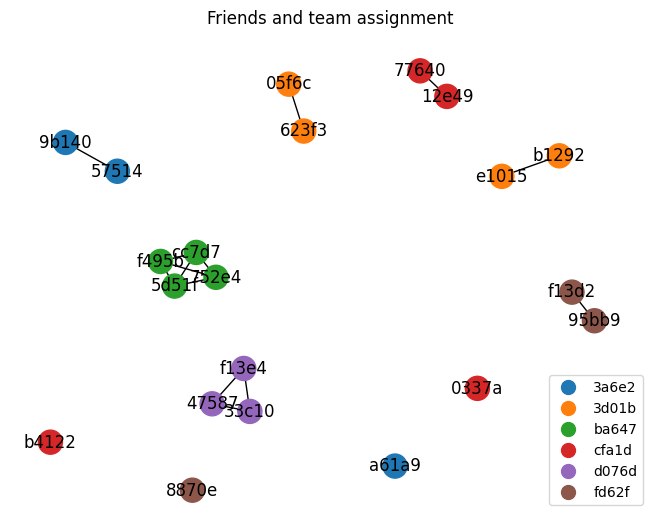

In [8]:
penalize = True
for l in [0.1]:
    P = 6
    lambda_mul = l
    x = run_experiments(input_file, lambda_mul)
    analysis(x)